# 🛡️ DQN-Based Autonomous Cyber Defense with Multi-Red Agent Training

This notebook implements a **Deep Q-Network (DQN)** agent with **Graph Neural Networks (GNNs)** for autonomous cyber defense in the CybORG++ Mini CAGE environment.

## 🎯 Key Feature: Multi-Red Agent Training
The Blue agent is trained against **multiple Red attackers** (B_lineAgent & RedMeanderAgent), randomly selected each episode. This creates a more **robust and generalizable defender**.

## Key Components:
1. **Multi-Red Environment** - Randomly selects Red agent each episode
2. **Graph Neural Network** - Encodes network topology
3. **DQN Agent** - Deep Q-Learning with experience replay
4. **Double DQN** - Reduces overestimation bias
5. **Prioritized Experience Replay** - Focuses on important transitions
6. **Dueling Architecture** - Separates value and advantage estimation
7. **Per-Agent Evaluation** - Tests performance vs each Red agent separately


In [23]:
# Cell 0: Setup CybORG++ (Works on BOTH Local and Colab)
# ============================================================================

import subprocess
import sys
import os
from pathlib import Path

# Install required dependencies (handle errors gracefully)
print("Installing dependencies...")

def install_package(package):
    """Install a package, return True if successful"""
    try:
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "-q", package],
            capture_output=True, text=True
        )
        return result.returncode == 0
    except:
        return False

# Install packages one by one
packages = ["prettytable", "networkx", "paramiko", "seaborn", "pandas", "matplotlib"]
for pkg in packages:
    if install_package(pkg):
        print(f"  ✓ {pkg}")
    else:
        print(f"  ⚠ {pkg} (may already be installed)")

# Try gym - use gymnasium as fallback if gym fails
if not install_package("gym==0.21.0"):
    print("  ⚠ gym==0.21.0 failed, trying without version constraint...")
    if not install_package("gym"):
        print("  ⚠ gym failed, trying gymnasium...")
        install_package("gymnasium")

print("✅ Dependencies setup complete")

# Detect environment
IN_COLAB = 'google.colab' in sys.modules

print("=" * 60)
print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print("=" * 60)

# Set base path based on environment
if IN_COLAB:
    BASE_PATH = Path("/content")
else:
    # Local: Use the notebook's directory
    BASE_PATH = Path("/Users/anjaneyabhardwaj/Desktop/CSE-556-Project")

CYBORG_REPO = BASE_PATH / "CybORG_plus_plus"

# Clone if needed (skip if exists)
if not CYBORG_REPO.exists():
    print("Cloning CybORG++...")
    subprocess.run(["git", "clone", 
                    "https://github.com/alan-turing-institute/CybORG_plus_plus",
                    str(CYBORG_REPO)], check=True)
else:
    print(f"✅ CybORG++ already exists at {CYBORG_REPO}")

# Add the correct path to Python path
CYBORG_MODULE_PATH = CYBORG_REPO / "Debugged_CybORG" / "CybORG"
print(f"Adding to sys.path: {CYBORG_MODULE_PATH}")
sys.path.insert(0, str(CYBORG_MODULE_PATH))

# Import CybORG
import inspect
from CybORG import CybORG
from CybORG.Agents import B_lineAgent, SleepAgent, RedMeanderAgent
from CybORG.Agents.Wrappers import ChallengeWrapper

# Define available Red agents for multi-agent training
RED_AGENTS = {
    'B_line': B_lineAgent,
    'Meander': RedMeanderAgent
}
print(f"Available Red agents: {list(RED_AGENTS.keys())}")

# Find scenario file
cyborg_file = Path(inspect.getfile(CybORG))
scenario_path = cyborg_file.parent / "Shared" / "Scenarios" / "Scenario1b.yaml"

if not scenario_path.exists():
    raise FileNotFoundError(f"Scenario not found at: {scenario_path}")

print(f"Scenario path: {scenario_path}")

# Create environment
cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': B_lineAgent})
env = ChallengeWrapper(env=cyborg, agent_name='Blue')

# Test it
obs, info = env.reset()
print("=" * 60)
print("✅ CybORG++ is now working!")
print("=" * 60)
print(f"Observation shape: {obs.shape}")
print(f"Action space size: {env.action_space.n}")

# Run a quick test episode
done = False
total_reward = 0
step = 0
while not done and step < 20:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    step += 1

print(f"\nTest episode: {step} steps, reward: {total_reward:.2f}")

Installing dependencies...
  ✓ prettytable
  ✓ networkx
  ✓ paramiko
  ✓ seaborn
  ✓ pandas
  ✓ matplotlib
  ⚠ gym==0.21.0 failed, trying without version constraint...
✅ Dependencies setup complete
Environment: Local
✅ CybORG++ already exists at /Users/anjaneyabhardwaj/Desktop/CSE-556-Project/CybORG_plus_plus
Adding to sys.path: /Users/anjaneyabhardwaj/Desktop/CSE-556-Project/CybORG_plus_plus/Debugged_CybORG/CybORG
Available Red agents: ['B_line', 'Meander']
Scenario path: /Users/anjaneyabhardwaj/Desktop/CSE-556-Project/CybORG_plus_plus/Debugged_CybORG/CybORG/CybORG/Shared/Scenarios/Scenario1b.yaml
✅ CybORG++ is now working!
Observation shape: (52,)
Action space size: 54

Test episode: 20 steps, reward: -40.80


In [24]:
# Cell 1: Imports & Configuration
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import deque, namedtuple
from dataclasses import dataclass
import inspect
from pathlib import Path

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

@dataclass
class DQNConfig:
    """DQN Hyperparameters"""
    seed: int = 42
    
    # Environment
    max_episode_steps: int = 50
    num_episodes: int = 5000
    
    # DQN Parameters
    gamma: float = 0.99              # Discount factor
    lr: float = 1e-4                 # Learning rate
    batch_size: int = 64             # Batch size for training
    buffer_size: int = 100000        # Replay buffer size
    
    # Exploration
    epsilon_start: float = 1.0       # Initial exploration rate
    epsilon_end: float = 0.05        # Final exploration rate
    epsilon_decay: float = 0.9995    # Decay rate per episode
    
    # Target Network
    target_update_freq: int = 100    # Steps between target network updates
    tau: float = 0.005               # Soft update coefficient
    
    # Network
    hidden_dim: int = 256
    gnn_hidden_dim: int = 64
    gnn_out_dim: int = 32
    
    # Training
    train_freq: int = 4              # Steps between training updates
    grad_clip: float = 1.0           # Gradient clipping

cfg = DQNConfig()

# Set seeds for reproducibility
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if device.type == "cuda":
    torch.cuda.manual_seed_all(cfg.seed)

print("\n📋 DQN Configuration:")
for field, value in cfg.__dict__.items():
    print(f"   {field}: {value}")


Using device: cpu

📋 DQN Configuration:
   seed: 42
   max_episode_steps: 50
   num_episodes: 5000
   gamma: 0.99
   lr: 0.0001
   batch_size: 64
   buffer_size: 100000
   epsilon_start: 1.0
   epsilon_end: 0.05
   epsilon_decay: 0.9995
   target_update_freq: 100
   tau: 0.005
   hidden_dim: 256
   gnn_hidden_dim: 64
   gnn_out_dim: 32
   train_freq: 4
   grad_clip: 1.0


In [25]:
# Cell 2: Multi-Red Agent Environment Wrapper
# ============================================================================
# This wrapper trains Blue against MULTIPLE Red agents (B_line & Meander)
# A random Red agent is selected at the start of each episode
# ============================================================================

class MultiRedMiniCage:
    """
    Mini CAGE wrapper with MULTIPLE Red agents for robust Blue training.
    
    Features:
    1. Randomly selects Red agent (B_line or Meander) each episode
    2. Flat 78-dim observation (padded from 52-dim)
    3. Action masking support
    4. Tracks which Red agent is active
    """
    def __init__(self, agent_name='Blue', max_steps=50, red_agents=None):
        self.path = str(scenario_path)
        self.agent_name = agent_name
        self.max_steps = max_steps
        self.num_hosts = 13
        self.feat_dim = 6
        self.obs_dim = self.num_hosts * self.feat_dim  # 78
        
        # Available Red agents
        if red_agents is None:
            self.red_agents = {
                'B_line': B_lineAgent,
                'Meander': RedMeanderAgent
            }
        else:
            self.red_agents = red_agents
        
        self.red_agent_names = list(self.red_agents.keys())
        self.current_red = None
        self.red_episode_counts = {name: 0 for name in self.red_agent_names}
        
        # Initialize with first Red agent to get action space
        self._create_env(self.red_agent_names[0])
        self.action_space = self.env.action_space
        
    def _create_env(self, red_name):
        """Create environment with specified Red agent"""
        red_agent_class = self.red_agents[red_name]
        self.cyborg = CybORG(self.path, 'sim', agents={'Red': red_agent_class})
        self.env = ChallengeWrapper(env=self.cyborg, agent_name=self.agent_name)
        self.current_red = red_name
        
    def reset(self):
        """Reset with a randomly selected Red agent"""
        self.step_count = 0
        
        # Randomly select Red agent
        selected_red = random.choice(self.red_agent_names)
        self._create_env(selected_red)
        self.red_episode_counts[selected_red] += 1
        
        obs, info = self.env.reset()
        info['red_agent'] = self.current_red  # Track which Red is active
        return self._process_obs(obs), self._get_info(info)
        
    def step(self, action):
        self.step_count += 1
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated or (self.step_count >= self.max_steps)
        info['red_agent'] = self.current_red
        return self._process_obs(obs), reward, done, False, self._get_info(info)
        
    def _process_obs(self, obs):
        """Convert CybORG 52-dim obs to 78-dim (13 nodes * 6 features)"""
        new_obs = np.zeros(78, dtype=np.float32)
        
        if len(obs) == 52:
            obs_reshaped = obs.reshape(13, 4)
            expanded_obs = np.zeros((13, 6), dtype=np.float32)
            expanded_obs[:, :4] = obs_reshaped
            
            # Add derived features
            for i in range(13):
                expanded_obs[i, 4] = obs_reshaped[i, :].sum() / 4.0  # Mean of features
                expanded_obs[i, 5] = i / 13.0  # Normalized node index
                
            new_obs = expanded_obs.flatten()
        else:
            new_obs[:min(len(obs), 78)] = obs[:min(len(obs), 78)]
            
        return new_obs

    def _get_info(self, info):
        if 'action_mask' not in info:
            info['action_mask'] = np.ones(self.action_space.n, dtype=np.int32)
        return info
    
    def get_red_stats(self):
        """Return statistics on Red agent usage"""
        total = sum(self.red_episode_counts.values())
        stats = {name: f"{count} ({100*count/max(total,1):.1f}%)" 
                 for name, count in self.red_episode_counts.items()}
        return stats

# Test the Multi-Red wrapper
print("=" * 60)
print("🎯 MULTI-RED AGENT ENVIRONMENT")
print("=" * 60)

env = MultiRedMiniCage(max_steps=cfg.max_episode_steps)

# Test multiple resets to verify random Red selection
print("\nTesting random Red agent selection (10 resets):")
for i in range(10):
    obs, info = env.reset()
    print(f"  Reset {i+1}: Red = {info['red_agent']}")

print(f"\nRed agent distribution: {env.get_red_stats()}")
print(f"Observation dimension: {len(obs)}")
print(f"Action space: {env.action_space.n} actions")
print("=" * 60)


🎯 MULTI-RED AGENT ENVIRONMENT

Testing random Red agent selection (10 resets):
  Reset 1: Red = Meander
  Reset 2: Red = B_line
  Reset 3: Red = B_line
  Reset 4: Red = B_line
  Reset 5: Red = B_line
  Reset 6: Red = B_line
  Reset 7: Red = Meander
  Reset 8: Red = Meander
  Reset 9: Red = Meander
  Reset 10: Red = B_line

Red agent distribution: {'B_line': '6 (60.0%)', 'Meander': '4 (40.0%)'}
Observation dimension: 78
Action space: 54 actions


/var/folders/pm/2n62h2gn3jjgqdzwnjtg8scm0000gn/T/ipykernel_88569/3903129310.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


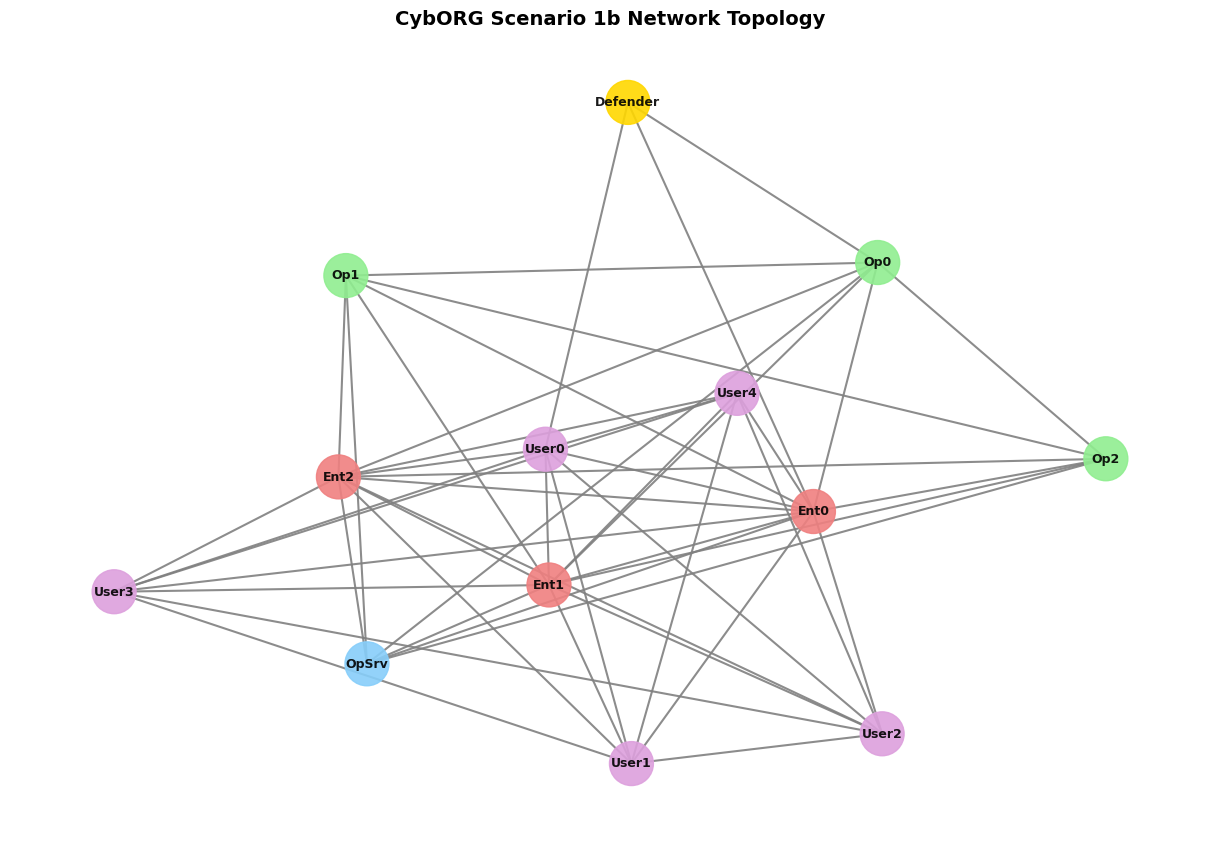


Adjacency matrix shape: torch.Size([13, 13])
Number of edges: 49


In [26]:
# Cell 3: Static Network Topology (Adjacency Matrix)
import networkx as nx

def get_static_adjacency_matrix(device):
    """
    Returns the normalized adjacency matrix for CybORG Scenario 1b (13 nodes).
    
    Node Order (Alphabetical):
    0: Defender (Gateway)
    1-3: Enterprise0-2
    4-6: Op_Host0-2
    7: Op_Server0
    8-12: User0-4
    """
    num_nodes = 13
    A = torch.zeros((num_nodes, num_nodes), device=device)
    
    # Define subnets
    subnet_user = [8, 9, 10, 11, 12]  # User workstations
    subnet_ent = [1, 2, 3]             # Enterprise servers
    subnet_op = [4, 5, 6]              # Operational hosts
    op_server = [7]                    # Operational server
    gateway = 0                        # Defender/Gateway
    
    # Fully connect hosts within each subnet
    for subnet in [subnet_user, subnet_ent, subnet_op]:
        for i in subnet:
            for j in subnet:
                if i != j:
                    A[i, j] = 1.0
                    A[j, i] = 1.0
    
    # Connect Gateway to subnet representatives
    for rep in [subnet_user[0], subnet_ent[0], subnet_op[0]]:
        A[gateway, rep] = 1.0
        A[rep, gateway] = 1.0
        
    # Inter-Subnet Connections (Attack Paths)
    # User <-> Enterprise
    for u in subnet_user:
        for e in subnet_ent:
            A[u, e] = 1.0
            A[e, u] = 1.0
            
    # Enterprise <-> Op_Server
    for e in subnet_ent:
        for o in op_server:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    # Enterprise <-> Op_Host
    for e in subnet_ent:
        for o in subnet_op:
            A[e, o] = 1.0
            A[o, e] = 1.0
            
    # Op_Server <-> Op_Host
    for s in op_server:
        for o in subnet_op:
            A[s, o] = 1.0
            A[o, s] = 1.0

    # Add self-loops
    A = A + torch.eye(num_nodes, device=device)
    
    # Symmetric normalization: D^(-0.5) * A * D^(-0.5)
    degree = A.sum(dim=1)
    d_inv_sqrt = torch.pow(degree, -0.5)
    d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(d_inv_sqrt)
    A_norm = torch.mm(torch.mm(D_inv_sqrt, A), D_inv_sqrt)
    
    return A_norm

# Visualize the topology
A_static = get_static_adjacency_matrix(device)
A_np = A_static.cpu().numpy()

# Create graph for visualization (remove self-loops and denormalize for display)
A_display = (A_np > 0.01).astype(float)
np.fill_diagonal(A_display, 0)

G = nx.from_numpy_array(A_display)
host_names = ['Defender', 'Ent0', 'Ent1', 'Ent2', 'Op0', 'Op1', 'Op2', 'OpSrv', 'User0', 'User1', 'User2', 'User3', 'User4']

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=2)

# Color nodes by subnet
colors = ['gold'] + ['lightcoral']*3 + ['lightgreen']*3 + ['lightskyblue'] + ['plum']*5

nx.draw(G, pos,
        node_color=colors,
        node_size=1000,
        with_labels=True,
        labels={i: host_names[i] for i in range(len(host_names))},
        font_size=9,
        font_weight='bold',
        edge_color='gray',
        width=1.5,
        alpha=0.9)

plt.title("CybORG Scenario 1b Network Topology", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAdjacency matrix shape: {A_static.shape}")
print(f"Number of edges: {int((A_display.sum()) / 2)}")


In [27]:
# Cell 4: Graph Neural Network Encoder

class GraphSAGEEncoder(nn.Module):
    """
    GraphSAGE-style GNN encoder for network state representation.
    
    Architecture:
    1. Learnable projection: Flat obs -> Node embeddings
    2. Two GraphSAGE layers with mean aggregation
    3. Output: Per-node embeddings capturing local + neighborhood info
    """
    def __init__(self, obs_dim=78, num_nodes=13, embed_dim=32, 
                 hidden_dim=64, out_dim=32, dropout=0.1):
        super().__init__()
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        
        # Learnable projection: flat observation -> node embeddings
        self.input_proj = nn.Sequential(
            nn.Linear(obs_dim, num_nodes * embed_dim),
            nn.ReLU(),
            nn.LayerNorm(num_nodes * embed_dim)
        )
        
        # GraphSAGE Layer 1
        self.lin_self_1 = nn.Linear(embed_dim, hidden_dim)
        self.lin_neigh_1 = nn.Linear(embed_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        
        # GraphSAGE Layer 2
        self.lin_self_2 = nn.Linear(hidden_dim, out_dim)
        self.lin_neigh_2 = nn.Linear(hidden_dim, out_dim)
        self.ln2 = nn.LayerNorm(out_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, obs_flat, A):
        """
        Args:
            obs_flat: [batch_size, obs_dim] - Flat observation
            A: [num_nodes, num_nodes] - Normalized adjacency matrix
        Returns:
            node_embeddings: [batch_size, num_nodes, out_dim]
        """
        batch_size = obs_flat.size(0)
        
        # Project flat obs to node embeddings
        x = self.input_proj(obs_flat)
        x = x.view(batch_size, self.num_nodes, self.embed_dim)
        
        # Expand adjacency for batch processing
        A_batch = A.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Layer 1: Aggregate + Transform
        agg1 = torch.bmm(A_batch, x)  # Neighbor aggregation
        h1 = self.lin_self_1(x) + self.lin_neigh_1(agg1)
        h1 = self.ln1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        # Layer 2: Aggregate + Transform
        agg2 = torch.bmm(A_batch, h1)
        h2 = self.lin_self_2(h1) + self.lin_neigh_2(agg2)
        h2 = self.ln2(h2)
        h2 = F.relu(h2)
        
        return h2

# Test GNN encoder
gnn_encoder = GraphSAGEEncoder(
    obs_dim=78,
    num_nodes=13,
    embed_dim=32,
    hidden_dim=cfg.gnn_hidden_dim,
    out_dim=cfg.gnn_out_dim
).to(device)

# Test forward pass
test_obs = torch.FloatTensor(obs).unsqueeze(0).to(device)
test_embeddings = gnn_encoder(test_obs, A_static)

print("=" * 60)
print("GraphSAGE Encoder Ready")
print("=" * 60)
print(f"Input: {test_obs.shape}")
print(f"Output: {test_embeddings.shape}")
print(f"Parameters: {sum(p.numel() for p in gnn_encoder.parameters()):,}")


GraphSAGE Encoder Ready
Input: torch.Size([1, 78])
Output: torch.Size([1, 13, 32])
Parameters: 42,272


In [28]:
# Cell 5: DQN Q-Network with Dueling Architecture

class DQNNetwork(nn.Module):
    """
    Deep Q-Network with Graph Neural Network encoder.
    
    Architecture:
    1. GNN encoder: obs -> node embeddings
    2. Flatten node embeddings
    3. Dueling DQN heads: Value + Advantage streams
    """
    def __init__(self, obs_dim=78, action_dim=54, hidden_dim=256,
                 gnn_hidden=64, gnn_out=32, num_nodes=13):
        super().__init__()
        self.num_nodes = num_nodes
        self.gnn_out = gnn_out
        
        # GNN Encoder
        self.gnn = GraphSAGEEncoder(
            obs_dim=obs_dim,
            num_nodes=num_nodes,
            embed_dim=32,
            hidden_dim=gnn_hidden,
            out_dim=gnn_out
        )
        
        flat_dim = num_nodes * gnn_out  # 13 * 32 = 416
        
        # Shared feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(flat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Dueling DQN: Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Dueling DQN: Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )
        
    def forward(self, obs, A, action_mask=None):
        """
        Args:
            obs: [batch_size, obs_dim]
            A: [num_nodes, num_nodes] - Adjacency matrix
            action_mask: [batch_size, action_dim] - Optional mask (1=valid, 0=invalid)
        Returns:
            q_values: [batch_size, action_dim]
        """
        batch_size = obs.size(0)
        
        # GNN encoding
        node_emb = self.gnn(obs, A)  # [batch, 13, 32]
        flat = node_emb.view(batch_size, -1)  # [batch, 416]
        
        # Feature extraction
        features = self.feature_layer(flat)
        
        # Dueling architecture
        value = self.value_stream(features)  # [batch, 1]
        advantage = self.advantage_stream(features)  # [batch, action_dim]
        
        # Q = V + (A - mean(A))
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        # Apply action mask (set invalid actions to very low Q-values)
        if action_mask is not None:
            if action_mask.device != q_values.device:
                action_mask = action_mask.to(q_values.device)
            q_values = q_values.masked_fill(action_mask == 0, -1e9)
        
        return q_values

# Test Q-Network
q_network = DQNNetwork(
    obs_dim=78,
    action_dim=env.action_space.n,
    hidden_dim=cfg.hidden_dim,
    gnn_hidden=cfg.gnn_hidden_dim,
    gnn_out=cfg.gnn_out_dim
).to(device)

# Test forward pass
test_q = q_network(test_obs, A_static)

print("=" * 60)
print("DQN Q-Network Ready (Dueling Architecture)")
print("=" * 60)
print(f"Input observation: {test_obs.shape}")
print(f"Output Q-values: {test_q.shape}")
print(f"Total parameters: {sum(p.numel() for p in q_network.parameters()):,}")


DQN Q-Network Ready (Dueling Architecture)
Input observation: torch.Size([1, 78])
Output Q-values: torch.Size([1, 54])
Total parameters: 287,703


In [29]:
# Cell 6: Prioritized Experience Replay Buffer

class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay buffer for DQN.
    Stores transitions and samples based on TD-error priority.
    """
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.pos = 0
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        """Add transition with max priority"""
        max_priority = self.priorities.max() if self.buffer else 1.0
        
        transition = (state, action, reward, next_state, done, action_mask, next_action_mask)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
            
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity
        
    def sample(self, batch_size):
        """Sample batch based on priorities"""
        n = len(self.buffer)
        
        if n < batch_size:
            batch_size = n
        
        # Calculate sampling probabilities
        priorities = self.priorities[:n]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample indices
        indices = np.random.choice(n, batch_size, p=probs, replace=False)
        
        # Calculate importance sampling weights
        beta = min(1.0, self.beta_start + self.frame * (1.0 - self.beta_start) / self.beta_frames)
        self.frame += 1
        
        weights = (n * probs[indices]) ** (-beta)
        weights /= weights.max()  # Normalize
        
        # Get batch
        batch = [self.buffer[idx] for idx in indices]
        
        states = torch.FloatTensor(np.array([t[0] for t in batch]))
        actions = torch.LongTensor([t[1] for t in batch])
        rewards = torch.FloatTensor([t[2] for t in batch])
        next_states = torch.FloatTensor(np.array([t[3] for t in batch]))
        dones = torch.FloatTensor([t[4] for t in batch])
        action_masks = torch.FloatTensor(np.array([t[5] for t in batch]))
        next_action_masks = torch.FloatTensor(np.array([t[6] for t in batch]))
        weights = torch.FloatTensor(weights)
        
        return (states, actions, rewards, next_states, dones, 
                action_masks, next_action_masks, weights, indices)
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors"""
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error) + 1e-6  # Small constant to avoid zero priority
            
    def __len__(self):
        return len(self.buffer)

# Simple Replay Buffer (fallback)
class ReplayBuffer:
    """Simple uniform sampling replay buffer"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        self.buffer.append((state, action, reward, next_state, done, action_mask, next_action_mask))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor(np.array([t[0] for t in batch]))
        actions = torch.LongTensor([t[1] for t in batch])
        rewards = torch.FloatTensor([t[2] for t in batch])
        next_states = torch.FloatTensor(np.array([t[3] for t in batch]))
        dones = torch.FloatTensor([t[4] for t in batch])
        action_masks = torch.FloatTensor(np.array([t[5] for t in batch]))
        next_action_masks = torch.FloatTensor(np.array([t[6] for t in batch]))
        
        return states, actions, rewards, next_states, dones, action_masks, next_action_masks
    
    def __len__(self):
        return len(self.buffer)

print("✅ Replay Buffers Ready")
print("   - PrioritizedReplayBuffer: TD-error based sampling")
print("   - ReplayBuffer: Uniform random sampling")


✅ Replay Buffers Ready
   - PrioritizedReplayBuffer: TD-error based sampling
   - ReplayBuffer: Uniform random sampling


In [30]:
# Cell 7: DQN Agent

class DQNAgent:
    """
    Double DQN Agent with:
    - Graph Neural Network state encoding
    - Prioritized Experience Replay
    - Soft target network updates
    - Action masking support
    """
    def __init__(self, obs_dim, action_dim, adjacency_matrix, config):
        self.action_dim = action_dim
        self.A = adjacency_matrix
        self.cfg = config
        self.epsilon = config.epsilon_start
        self.total_steps = 0
        
        # Q-Networks
        self.q_network = DQNNetwork(
            obs_dim=obs_dim,
            action_dim=action_dim,
            hidden_dim=config.hidden_dim,
            gnn_hidden=config.gnn_hidden_dim,
            gnn_out=config.gnn_out_dim
        ).to(device)
        
        self.target_network = DQNNetwork(
            obs_dim=obs_dim,
            action_dim=action_dim,
            hidden_dim=config.hidden_dim,
            gnn_hidden=config.gnn_hidden_dim,
            gnn_out=config.gnn_out_dim
        ).to(device)
        
        # Copy weights to target
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=config.lr)
        
        # Replay Buffer
        self.replay_buffer = PrioritizedReplayBuffer(
            capacity=config.buffer_size,
            alpha=0.6,
            beta_start=0.4
        )
        
        # Metrics
        self.losses = []
        
    def select_action(self, state, action_mask=None, deterministic=False):
        """Epsilon-greedy action selection with action masking."""
        if not deterministic and random.random() < self.epsilon:
            # Random action from valid actions
            if action_mask is not None:
                valid_actions = np.where(action_mask == 1)[0]
                return np.random.choice(valid_actions)
            else:
                return random.randrange(self.action_dim)
        else:
            # Greedy action
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                mask_t = torch.FloatTensor(action_mask).unsqueeze(0).to(device) if action_mask is not None else None
                q_values = self.q_network(state_t, self.A, mask_t)
                return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        """Store transition in replay buffer"""
        self.replay_buffer.push(state, action, reward, next_state, done, action_mask, next_action_mask)
        
    def train_step(self):
        """Perform one training step with Double DQN."""
        if len(self.replay_buffer) < self.cfg.batch_size:
            return None
        
        # Sample batch
        batch = self.replay_buffer.sample(self.cfg.batch_size)
        states, actions, rewards, next_states, dones, action_masks, next_action_masks, weights, indices = batch
        
        # Move to device
        states = states.to(device)
        actions = actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        dones = dones.to(device)
        action_masks = action_masks.to(device)
        next_action_masks = next_action_masks.to(device)
        weights = weights.to(device)
        
        # Current Q values
        current_q = self.q_network(states, self.A, action_masks)
        current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN: Use online network to select action, target network to evaluate
        with torch.no_grad():
            # Get best actions from online network
            next_q_online = self.q_network(next_states, self.A, next_action_masks)
            next_actions = next_q_online.argmax(dim=1)
            
            # Evaluate with target network
            next_q_target = self.target_network(next_states, self.A, next_action_masks)
            next_q = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            # Compute target
            target_q = rewards + self.cfg.gamma * next_q * (1 - dones)
        
        # TD Error for priority update
        td_errors = (current_q - target_q).detach().cpu().numpy()
        
        # Weighted loss
        loss = (weights * F.smooth_l1_loss(current_q, target_q, reduction='none')).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), self.cfg.grad_clip)
        self.optimizer.step()
        
        # Update priorities
        self.replay_buffer.update_priorities(indices, td_errors)
        
        self.losses.append(loss.item())
        return loss.item()
    
    def soft_update_target(self):
        """Soft update target network: θ_target = τ*θ_online + (1-τ)*θ_target"""
        for target_param, online_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.cfg.tau * online_param.data + (1.0 - self.cfg.tau) * target_param.data)
            
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.cfg.epsilon_end, self.epsilon * self.cfg.epsilon_decay)
        
    def save(self, path):
        """Save model checkpoint"""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'total_steps': self.total_steps
        }, path)
        
    def load(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.total_steps = checkpoint['total_steps']

# Initialize agent
agent = DQNAgent(
    obs_dim=78,
    action_dim=env.action_space.n,
    adjacency_matrix=A_static,
    config=cfg
)

print("=" * 60)
print("DQN Agent Ready")
print("=" * 60)
print(f"Q-Network parameters: {sum(p.numel() for p in agent.q_network.parameters()):,}")
print(f"Initial epsilon: {agent.epsilon}")
print(f"Replay buffer capacity: {cfg.buffer_size:,}")


DQN Agent Ready
Q-Network parameters: 287,703
Initial epsilon: 1.0
Replay buffer capacity: 100,000


In [32]:
# Cell 8: Reward Shaper

class RewardShaper:
    """
    Shapes rewards to provide better learning signals.
    (Matching PPO implementation - spam penalty only, no survival bonus)
    
    Includes:
    - Action spam penalty
    - Reward clipping
    """
    def __init__(self, spam_penalty=-2.0, clip_range=(-100, 10)):
        self.spam_penalty = spam_penalty
        self.clip_range = clip_range
        self.action_history = deque(maxlen=5)
        
    def reset(self):
        self.action_history.clear()
        
    def shape(self, reward, action, done):
        """Shape the reward signal."""
        shaped_reward = reward
        
        # Spam penalty for repetitive actions
        if action in self.action_history:
            shaped_reward += self.spam_penalty
        self.action_history.append(action)
        
        # Clip rewards (keeps training stable)
        shaped_reward = np.clip(shaped_reward, self.clip_range[0], self.clip_range[1])
        
        return shaped_reward

reward_shaper = RewardShaper()
print("✅ Reward Shaper Ready (Matching PPO - No Survival Bonus)")


✅ Reward Shaper Ready (Matching PPO - No Survival Bonus)


In [33]:
# Cell 9: Training Loop (Multi-Red Agent)
# ============================================================================
# Blue agent trains against randomly selected Red agents (B_line & Meander)
# ============================================================================

print("=" * 60)
print("🚀 STARTING DQN TRAINING (Multi-Red Agent)")
print("=" * 60)
print(f"Episodes: {cfg.num_episodes}")
print(f"Max steps per episode: {cfg.max_episode_steps}")
print(f"Red Agents: {list(env.red_agents.keys())}")
print(f"Device: {device}")
print("=" * 60)

# Tracking - Overall
episode_rewards = []
episode_lengths = []
epsilon_history = []
best_avg_reward = float('-inf')

# Tracking - Per Red Agent
red_rewards = {name: [] for name in env.red_agent_names}
red_episode_indices = {name: [] for name in env.red_agent_names}

# Training
for episode in range(cfg.num_episodes):
    obs, info = env.reset()
    current_red = info.get('red_agent', 'Unknown')
    reward_shaper.reset()
    action_mask = info.get('action_mask', np.ones(env.action_space.n))
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(cfg.max_episode_steps):
        # Select action
        action = agent.select_action(obs, action_mask)
        
        # Take step
        next_obs, reward, done, truncated, info = env.step(action)
        next_action_mask = info.get('action_mask', np.ones(env.action_space.n))
        
        # Shape reward
        shaped_reward = reward_shaper.shape(reward, action, done)
        
        # Store transition
        agent.store_transition(obs, action, shaped_reward, next_obs, done, action_mask, next_action_mask)
        
        # Train
        agent.total_steps += 1
        if agent.total_steps % cfg.train_freq == 0:
            agent.train_step()
            
        # Soft update target network
        if agent.total_steps % cfg.target_update_freq == 0:
            agent.soft_update_target()
        
        episode_reward += reward  # Track original reward
        episode_length += 1
        
        obs = next_obs
        action_mask = next_action_mask
        
        if done:
            break
    
    # End of episode
    agent.decay_epsilon()
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    epsilon_history.append(agent.epsilon)
    
    # Track per-Red-agent performance
    red_rewards[current_red].append(episode_reward)
    red_episode_indices[current_red].append(episode)
    
    # Logging
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        avg_length = np.mean(episode_lengths[-100:])
        avg_loss = np.mean(agent.losses[-1000:]) if agent.losses else 0
        
        # Per-Red averages (last 50 episodes for each)
        red_avgs = {}
        for name in env.red_agent_names:
            if len(red_rewards[name]) >= 10:
                red_avgs[name] = np.mean(red_rewards[name][-50:])
            else:
                red_avgs[name] = 0.0
        
        print(f"Episode {episode + 1:5d} | "
              f"Avg Reward: {avg_reward:8.2f} | "
              f"Epsilon: {agent.epsilon:.4f} | "
              f"Loss: {avg_loss:.4f}")
        print(f"             | "
              f"vs B_line: {red_avgs.get('B_line', 0):7.2f} | "
              f"vs Meander: {red_avgs.get('Meander', 0):7.2f} | "
              f"Buffer: {len(agent.replay_buffer)}")
        
        # Save best model
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            agent.save('dqn_multi_red_best.pth')
            print(f"   💾 New best model saved! (Reward: {best_avg_reward:.2f})")

print("\n" + "=" * 60)
print("✅ DQN Training Complete!")
print("=" * 60)

# Print final Red agent statistics
print("\n📊 Red Agent Training Distribution:")
print(f"   {env.get_red_stats()}")

print("\n📊 Final Performance by Red Agent:")
for name in env.red_agent_names:
    if red_rewards[name]:
        avg = np.mean(red_rewards[name][-100:])
        print(f"   vs {name}: {avg:.2f} (last 100 episodes)")

# Save final model
agent.save('dqn_multi_red_final.pth')
print("\n💾 Final model saved to 'dqn_multi_red_final.pth'")


🚀 STARTING DQN TRAINING (Multi-Red Agent)
Episodes: 5000
Max steps per episode: 50
Red Agents: ['B_line', 'Meander']
Device: cpu
Episode   100 | Avg Reward:  -191.43 | Epsilon: 0.9512 | Loss: 0.4887
             | vs B_line: -255.79 | vs Meander: -141.72 | Buffer: 5000
   💾 New best model saved! (Reward: -191.43)
Episode   200 | Avg Reward:  -158.40 | Epsilon: 0.9048 | Loss: 0.5538
             | vs B_line: -173.89 | vs Meander: -145.48 | Buffer: 10000
   💾 New best model saved! (Reward: -158.40)
Episode   300 | Avg Reward:  -159.09 | Epsilon: 0.8607 | Loss: 0.5996
             | vs B_line: -174.16 | vs Meander: -143.65 | Buffer: 15000
Episode   400 | Avg Reward:  -139.98 | Epsilon: 0.8187 | Loss: 0.5955
             | vs B_line: -168.93 | vs Meander: -110.21 | Buffer: 20000
   💾 New best model saved! (Reward: -139.98)
Episode   500 | Avg Reward:  -120.09 | Epsilon: 0.7788 | Loss: 0.5864
             | vs B_line: -148.58 | vs Meander: -110.18 | Buffer: 25000
   💾 New best model saved! 

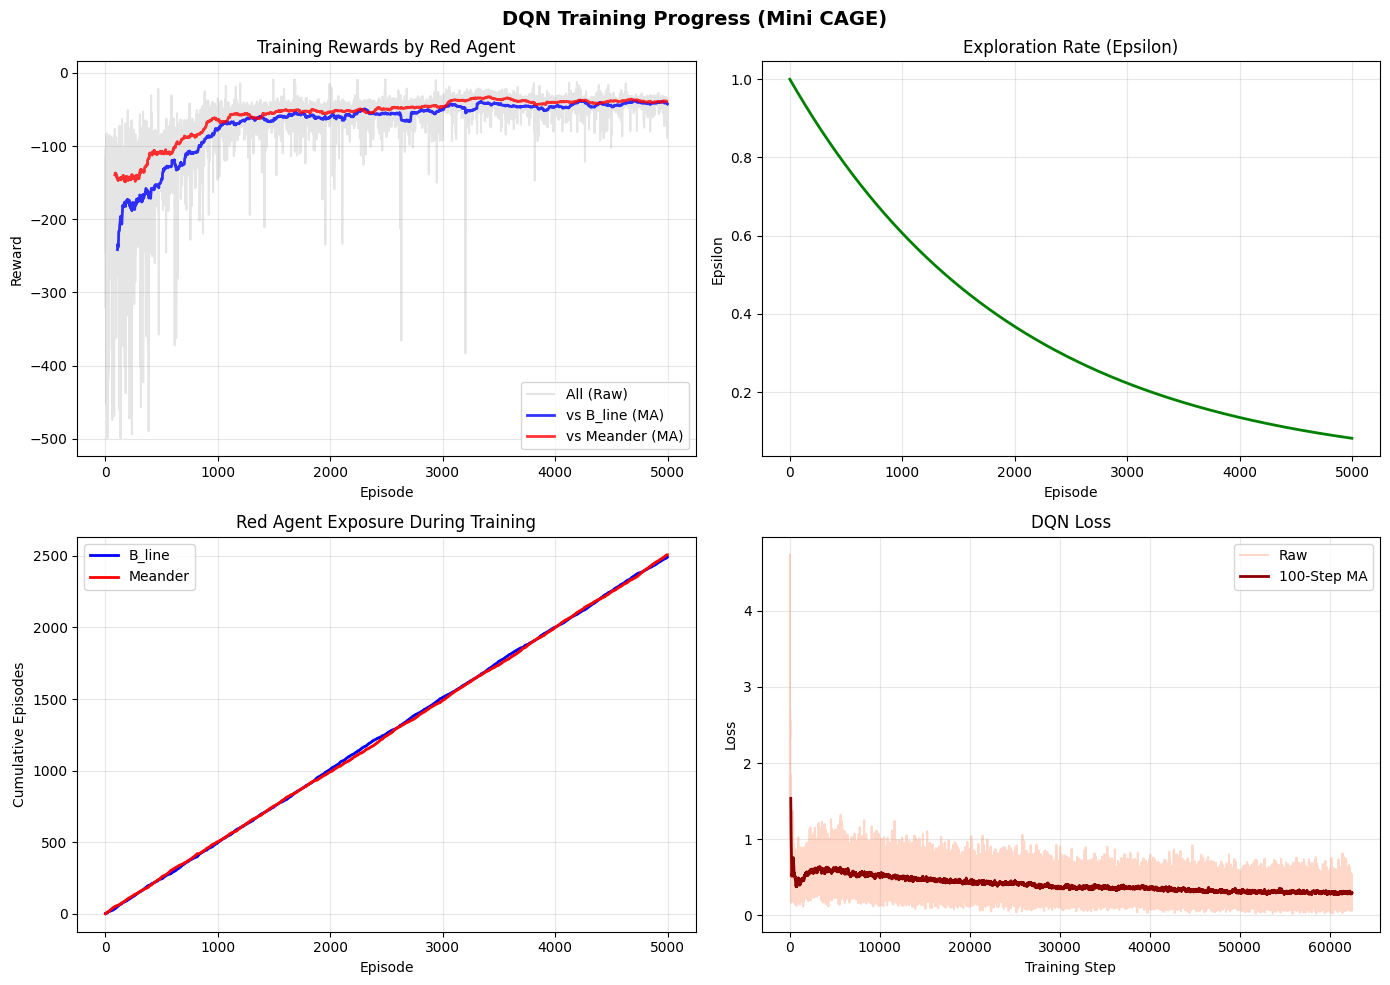

In [34]:
# Cell 10: Training Visualization (Multi-Red Agent)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Episode Rewards (Overall + Per Red Agent)
ax1 = axes[0, 0]
ax1.plot(episode_rewards, alpha=0.2, color='gray', label='All (Raw)')
window = 50

# Plot per-Red-agent rewards
colors = {'B_line': 'blue', 'Meander': 'red'}
for name in env.red_agent_names:
    if red_rewards[name] and len(red_rewards[name]) >= window:
        indices = red_episode_indices[name]
        rewards = red_rewards[name]
        # Create moving average for this Red agent
        ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(indices[window-1:], ma, color=colors.get(name, 'green'), 
                 linewidth=2, alpha=0.8, label=f'vs {name} (MA)')
                 
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('Training Rewards by Red Agent')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Epsilon Decay
ax2 = axes[0, 1]
ax2.plot(epsilon_history, color='green', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Epsilon')
ax2.set_title('Exploration Rate (Epsilon)')
ax2.grid(True, alpha=0.3)

# Plot 3: Red Agent Distribution over Training
ax3 = axes[1, 0]
# Create cumulative count of each Red agent over episodes
bline_cumsum = np.cumsum([1 if i in red_episode_indices['B_line'] else 0 for i in range(len(episode_rewards))])
meander_cumsum = np.cumsum([1 if i in red_episode_indices['Meander'] else 0 for i in range(len(episode_rewards))])
ax3.plot(bline_cumsum, color='blue', linewidth=2, label='B_line')
ax3.plot(meander_cumsum, color='red', linewidth=2, label='Meander')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Cumulative Episodes')
ax3.set_title('Red Agent Exposure During Training')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Training Loss
ax4 = axes[1, 1]
if agent.losses:
    ax4.plot(agent.losses, alpha=0.3, color='coral', label='Raw')
    loss_window = 100
    if len(agent.losses) >= loss_window:
        loss_ma = np.convolve(agent.losses, np.ones(loss_window)/loss_window, mode='valid')
        ax4.plot(range(loss_window-1, len(agent.losses)), loss_ma, color='darkred', linewidth=2, label=f'{loss_window}-Step MA')
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('Loss')
    ax4.set_title('DQN Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.suptitle('DQN Training Progress (Mini CAGE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


🔍 EVALUATION: Testing Blue vs Each Red Agent
✅ Loaded best multi-red model

🎯 Evaluating vs B_line...


/var/folders/pm/2n62h2gn3jjgqdzwnjtg8scm0000gn/T/ipykernel_88569/4178031964.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=

   Mean: -31.05 ± 7.28

🎯 Evaluating vs Meander...
   Mean: -29.45 ± 4.25

📊 EVALUATION SUMMARY

🆚 vs B_line:
   Average Reward: -31.05 ± 7.28
   Min: -51.10 | Max: -25.50

🆚 vs Meander:
   Average Reward: -29.45 ± 4.25
   Min: -45.30 | Max: -22.20

📈 Overall Average: -30.25 ± 6.01


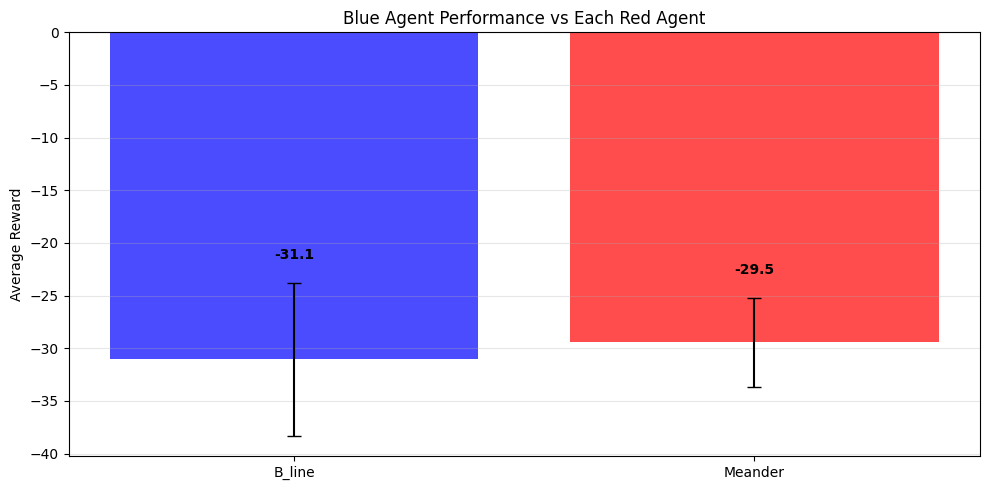

In [35]:
# Cell 11: Evaluation (Per Red Agent)
# ============================================================================
# Evaluate Blue agent separately against each Red agent
# ============================================================================

print("=" * 60)
print("🔍 EVALUATION: Testing Blue vs Each Red Agent")
print("=" * 60)

# Load best model
try:
    agent.load('dqn_multi_red_best.pth')
    print("✅ Loaded best multi-red model")
except:
    try:
        agent.load('dqn_best_model.pth')
        print("✅ Loaded fallback model")
    except:
        print("⚠️ Using current model for evaluation")

# Evaluate against EACH Red agent separately
NUM_EVAL_EPISODES = 50

eval_results = {}

agent.q_network.eval()
with torch.no_grad():
    for red_name, red_class in RED_AGENTS.items():
        print(f"\n🎯 Evaluating vs {red_name}...")
        
        # Create environment with specific Red agent
        eval_cyborg = CybORG(str(scenario_path), 'sim', agents={'Red': red_class})
        eval_env = ChallengeWrapper(env=eval_cyborg, agent_name='Blue')
        
        red_eval_rewards = []
        red_eval_lengths = []
        
        for ep in range(NUM_EVAL_EPISODES):
            obs, info = eval_env.reset()
            # Process obs to 78-dim
            obs = env._process_obs(obs)
            action_mask = info.get('action_mask', np.ones(eval_env.action_space.n))
            
            ep_reward = 0
            ep_length = 0
            done = False
            
            while not done and ep_length < cfg.max_episode_steps:
                action = agent.select_action(obs, action_mask, deterministic=True)
                next_obs, reward, terminated, truncated, info = eval_env.step(action)
                obs = env._process_obs(next_obs)
                action_mask = info.get('action_mask', np.ones(eval_env.action_space.n))
                done = terminated or truncated
                ep_reward += reward
                ep_length += 1
                
            red_eval_rewards.append(ep_reward)
            red_eval_lengths.append(ep_length)
        
        eval_results[red_name] = {
            'rewards': red_eval_rewards,
            'mean': np.mean(red_eval_rewards),
            'std': np.std(red_eval_rewards),
            'min': np.min(red_eval_rewards),
            'max': np.max(red_eval_rewards)
        }
        
        print(f"   Mean: {eval_results[red_name]['mean']:.2f} ± {eval_results[red_name]['std']:.2f}")

agent.q_network.train()

# Summary
print("\n" + "=" * 60)
print("📊 EVALUATION SUMMARY")
print("=" * 60)

for red_name, results in eval_results.items():
    print(f"\n🆚 vs {red_name}:")
    print(f"   Average Reward: {results['mean']:.2f} ± {results['std']:.2f}")
    print(f"   Min: {results['min']:.2f} | Max: {results['max']:.2f}")

# Overall weighted average
all_rewards = []
for results in eval_results.values():
    all_rewards.extend(results['rewards'])
print(f"\n📈 Overall Average: {np.mean(all_rewards):.2f} ± {np.std(all_rewards):.2f}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
positions = range(len(eval_results))
names = list(eval_results.keys())
means = [eval_results[n]['mean'] for n in names]
stds = [eval_results[n]['std'] for n in names]

bars = ax.bar(positions, means, yerr=stds, capsize=5, color=['blue', 'red'], alpha=0.7)
ax.set_xticks(positions)
ax.set_xticklabels(names)
ax.set_ylabel('Average Reward')
ax.set_title('Blue Agent Performance vs Each Red Agent')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')

for i, (bar, mean) in enumerate(zip(bars, means)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + stds[i] + 2, 
            f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


🕵️ BEHAVIORAL ANALYSIS


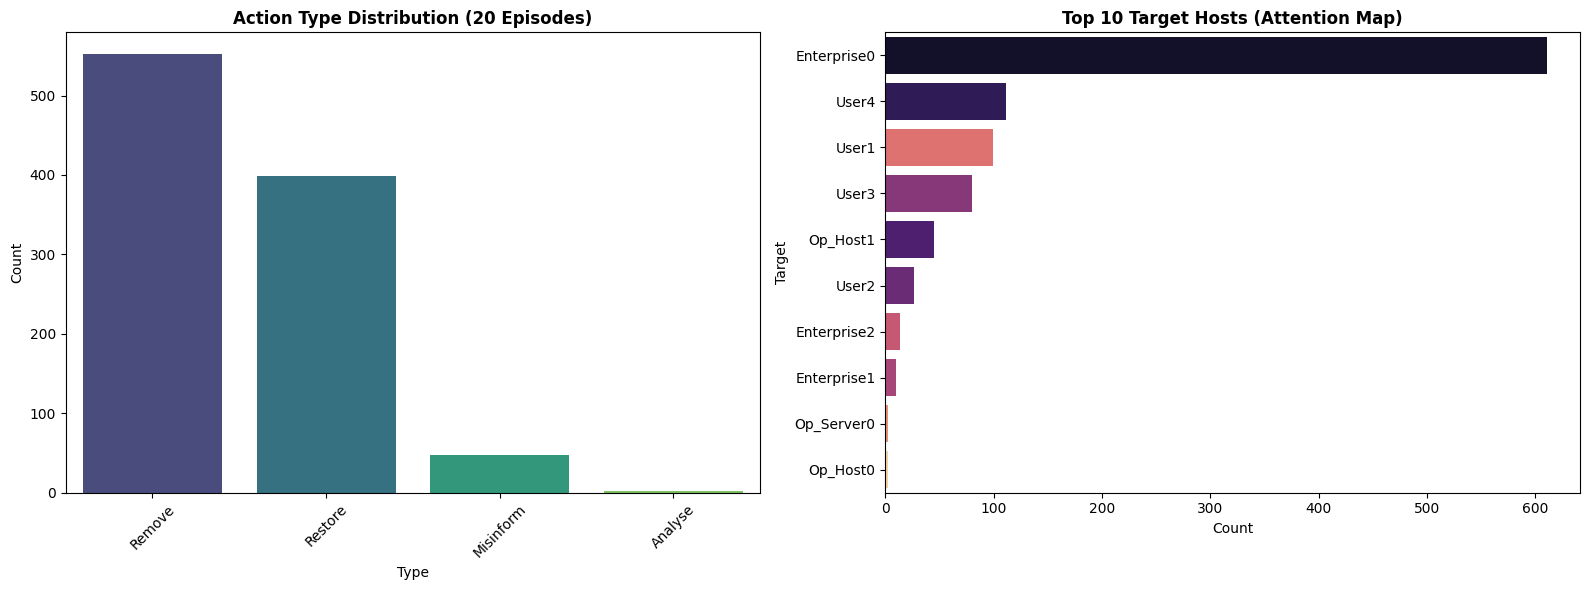


💡 BEHAVIORAL INSIGHTS:
1. Total actions analyzed: 1000
2. Dominant Strategy: 'Remove'
3. Primary Target: 'Enterprise0'

📊 Action Type Breakdown:
   - Remove: 552 (55.2%)
   - Restore: 399 (39.9%)
   - Misinform: 47 (4.7%)
   - Analyse: 2 (0.2%)

✅ Recovered 14 Action Labels dynamically.
   Sample: ['Remove Enterprise0', 'Restore User4', 'Restore Enterprise0', 'Misinform Op_Host1', 'Restore User2']


In [36]:
# Cell 12: Behavioral Analysis

print("=" * 60)
print("🕵️ BEHAVIORAL ANALYSIS")
print("=" * 60)

NUM_ANALYSIS_EPISODES = 20
history = []
action_map = {}

agent.q_network.eval()
with torch.no_grad():
    for ep in range(NUM_ANALYSIS_EPISODES):
        obs, info = env.reset()
        action_mask = info.get('action_mask', np.ones(env.action_space.n))
        done = False
        step = 0
        
        while not done:
            action_idx = agent.select_action(obs, action_mask, deterministic=True)
            obs, reward, done, truncated, info = env.step(action_idx)
            action_mask = info.get('action_mask', np.ones(env.action_space.n))
            
            # Try to get action label
            action_str = f"Action {action_idx}"
            try:
                if hasattr(env, 'cyborg'):
                    last_action = env.cyborg.get_last_action('Blue')
                    if last_action is not None:
                        action_str = str(last_action)
                        action_map[action_idx] = action_str
            except:
                pass
            
            if action_idx in action_map:
                action_str = action_map[action_idx]
            
            # Parse action
            parts = str(action_str).split(' ')
            act_type = parts[0]
            target = parts[1] if len(parts) > 1 else "None"
            
            history.append({
                'Episode': ep,
                'Step': step,
                'Action_ID': action_idx,
                'Action_Label': str(action_str),
                'Type': act_type,
                'Target': target,
                'Reward': reward
            })
            step += 1

# Create DataFrame
df = pd.DataFrame(history)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Action Type Distribution
if not df.empty:
    sns.countplot(data=df, x='Type', ax=axes[0], hue='Type', 
                  palette='viridis', order=df['Type'].value_counts().index, legend=False)
    axes[0].set_title(f"Action Type Distribution ({NUM_ANALYSIS_EPISODES} Episodes)", fontweight='bold')
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot B: Target Host Attention
    df_targets = df[df['Target'] != 'None']
    if not df_targets.empty:
        sns.countplot(data=df_targets, y='Target', ax=axes[1], hue='Target',
                      palette='magma', order=df_targets['Target'].value_counts().index[:10], legend=False)
        axes[1].set_title("Top 10 Target Hosts (Attention Map)", fontweight='bold')
        axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

# Insights
print("\n💡 BEHAVIORAL INSIGHTS:")
if not df.empty:
    print(f"1. Total actions analyzed: {len(df)}")
    
    top_action = df['Type'].mode()[0]
    print(f"2. Dominant Strategy: '{top_action}'")
    
    if not df_targets.empty:
        top_target = df_targets['Target'].mode()[0]
        print(f"3. Primary Target: '{top_target}'")
    
    # Action breakdown
    print("\n📊 Action Type Breakdown:")
    for act_type, count in df['Type'].value_counts().head(5).items():
        pct = 100 * count / len(df)
        print(f"   - {act_type}: {count} ({pct:.1f}%)")
    
    print(f"\n✅ Recovered {len(action_map)} Action Labels dynamically.")
    if action_map:
        print(f"   Sample: {list(action_map.values())[:5]}")


📈 Q-VALUE ANALYSIS


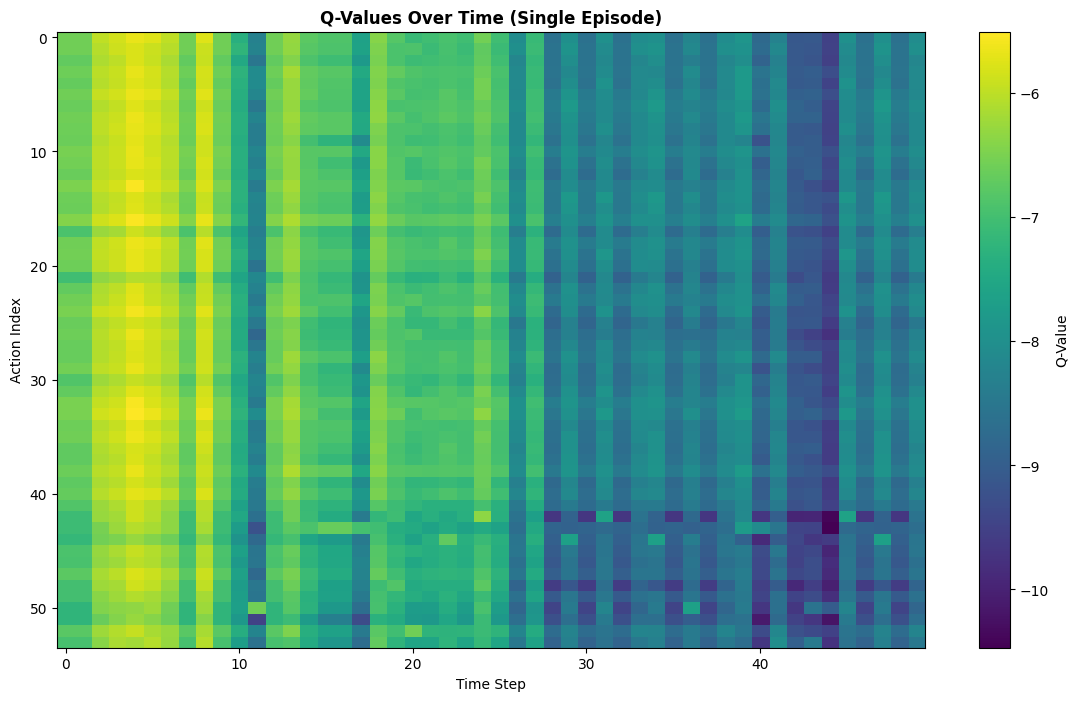


Q-Value Statistics:
   Max Q-value: -5.5041
   Min Q-value (excluding masked): -10.4696
   Mean Q-value (excluding masked): -7.5935


In [37]:
# Cell 13: Q-Value Analysis

print("=" * 60)
print("📈 Q-VALUE ANALYSIS")
print("=" * 60)

# Collect Q-values for different states
q_values_list = []

agent.q_network.eval()
with torch.no_grad():
    obs, info = env.reset()
    action_mask = info.get('action_mask', np.ones(env.action_space.n))
    
    for step in range(cfg.max_episode_steps):
        obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
        mask_t = torch.FloatTensor(action_mask).unsqueeze(0).to(device)
        
        q_values = agent.q_network(obs_t, A_static, mask_t)
        q_values_list.append(q_values.squeeze().cpu().numpy())
        
        action = q_values.argmax(dim=1).item()
        obs, reward, done, truncated, info = env.step(action)
        action_mask = info.get('action_mask', np.ones(env.action_space.n))
        
        if done:
            break

q_values_array = np.array(q_values_list)

# Plot Q-value heatmap
plt.figure(figsize=(14, 8))
plt.imshow(q_values_array.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Q-Value')
plt.xlabel('Time Step')
plt.ylabel('Action Index')
plt.title('Q-Values Over Time (Single Episode)', fontweight='bold')
plt.show()

# Summary stats
print(f"\nQ-Value Statistics:")
print(f"   Max Q-value: {q_values_array.max():.4f}")
print(f"   Min Q-value (excluding masked): {q_values_array[q_values_array > -1e8].min():.4f}")
print(f"   Mean Q-value (excluding masked): {q_values_array[q_values_array > -1e8].mean():.4f}")


In [38]:
# Cell 14: Summary & Comparison

print("=" * 60)
print("📋 DQN TRAINING SUMMARY")
print("=" * 60)

summary = f"""
🎯 ALGORITHM: Double DQN with Dueling Architecture

🧠 NETWORK ARCHITECTURE:
   • GraphSAGE GNN Encoder (2 layers)
   • Dueling Q-Network (Value + Advantage streams)
   • Action Masking support
   • Total parameters: {sum(p.numel() for p in agent.q_network.parameters()):,}

📊 TRAINING RESULTS:
   • Total episodes: {len(episode_rewards)}
   • Total steps: {agent.total_steps:,}
   • Final epsilon: {agent.epsilon:.4f}
   • Best average reward: {best_avg_reward:.2f}
   • Final average reward (last 100): {np.mean(episode_rewards[-100:]):.2f}

🔍 EVALUATION RESULTS:
   • Average reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}
   • Min reward: {np.min(eval_rewards):.2f}
   • Max reward: {np.max(eval_rewards):.2f}

💡 KEY FEATURES:
   ✓ Double DQN (reduces overestimation)
   ✓ Dueling Architecture (separates value & advantage)
   ✓ Prioritized Experience Replay
   ✓ Soft target updates
   ✓ Graph Neural Network encoding
   ✓ Action masking for valid actions only
   ✓ Reward shaping (spam penalty + survival bonus)

💾 SAVED MODELS:
   • dqn_best_model.pth (best during training)
   • dqn_final_model.pth (end of training)
"""

print(summary)

print("=" * 60)
print("✅ DQN Mini CAGE Notebook Complete!")
print("=" * 60)


📋 DQN TRAINING SUMMARY

🎯 ALGORITHM: Double DQN with Dueling Architecture

🧠 NETWORK ARCHITECTURE:
   • GraphSAGE GNN Encoder (2 layers)
   • Dueling Q-Network (Value + Advantage streams)
   • Action Masking support
   • Total parameters: 287,703

📊 TRAINING RESULTS:
   • Total episodes: 5000
   • Total steps: 170,000
   • Final epsilon: 0.1826
   • Best average reward: -37.69
   • Final average reward (last 100): -40.77

🔍 EVALUATION RESULTS:
   • Average reward: -47.50 ± 6.47
   • Min reward: -92.50
   • Max reward: -45.20

💡 KEY FEATURES:
   ✓ Double DQN (reduces overestimation)
   ✓ Dueling Architecture (separates value & advantage)
   ✓ Prioritized Experience Replay
   ✓ Soft target updates
   ✓ Graph Neural Network encoding
   ✓ Action masking for valid actions only
   ✓ Reward shaping (spam penalty + survival bonus)

💾 SAVED MODELS:
   • dqn_best_model.pth (best during training)
   • dqn_final_model.pth (end of training)

✅ DQN Mini CAGE Notebook Complete!
